In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt. 

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

## Set-up

Download the [model checkpoint](https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth) and put it in `checkpoints` folder.

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=100):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [4]:
def adjust_histogram(image):
    
    
    # Create a window to display the histogram and trackbars
    cv2.namedWindow('Adjust Histogram')

    # Create trackbars for adjusting the knobs
    cv2.createTrackbar('Min', 'Adjust Histogram', 0, 255, lambda x: None)
    cv2.createTrackbar('Max', 'Adjust Histogram', 255, 255, lambda x: None)

    while True:
        # Get the current trackbar positions
        min_val = cv2.getTrackbarPos('Min', 'Adjust Histogram')
        max_val = cv2.getTrackbarPos('Max', 'Adjust Histogram')

        # Clip the image values based on the knobs for each channel
        adjusted_image = np.clip(image, min_val, max_val)

        # Normalize the image values between min_val and max_val for each channel
        adjusted_image = np.interp(adjusted_image, [min_val, max_val], [0, 255])

        # Convert the adjusted image to 8-bit unsigned integers
        adjusted_image = adjusted_image.astype(np.uint8)

        # Display the adjusted image
        cv2.imshow('Adjusted Image', cv2.cvtColor(adjusted_image, cv2.COLOR_BGR2RGB))

        # Calculate the histogram of the adjusted image for each channel
        channels = cv2.split(adjusted_image)
        hist_r = cv2.calcHist([channels[0]], [0], None, [256], [0, 256])
        hist_g = cv2.calcHist([channels[1]], [0], None, [256], [0, 256])
        hist_b = cv2.calcHist([channels[2]], [0], None, [256], [0, 256])

        # Normalize the histograms
        hist_r = cv2.normalize(hist_r, hist_r, 0, 255, cv2.NORM_MINMAX)
        hist_g = cv2.normalize(hist_g, hist_g, 0, 255, cv2.NORM_MINMAX)
        hist_b = cv2.normalize(hist_b, hist_b, 0, 255, cv2.NORM_MINMAX)

        # Create a black canvas to draw the histograms
        canvas = np.zeros((256, 256, 3), np.uint8)

        # Draw the histograms on the canvas
        for i in range(256):
            cv2.line(canvas, (i, 256), (i, 256 - int(hist_r[i])), (0, 0, 255))
            cv2.line(canvas, (i, 512), (i, 512 - int(hist_g[i])), (0, 255, 0))
            cv2.line(canvas, (i, 768), (i, 768 - int(hist_b[i])), (255, 0, 0))

        # Display the histograms
        cv2.imshow('Histogram', canvas)

        # Wait for key press (press 'q' to quit)
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break

    # Release the window and resources
    cv2.destroyAllWindows()

    return adjusted_image

def annotate_image(image):
    # Create a copy of the image to draw annotations on
    annotated_image = image.copy()

    # Create lists to store the annotated points and boxes
    points = []
    boxes = []
    point_labels = []
    unscaled_points = []  # To store unscaled points
    unscaled_boxes = []  # To store unscaled boxes

    # Flag to indicate annotation mode (True for points, False for boxes)
    point_mode = True

    # Zoom parameters
    zoom_factor = 1.0
    zoom_scale = 0.1

    # Mouse callback function
    def annotate_callback(event, x, y, flags, param):
        nonlocal points, boxes, point_labels, unscaled_points, unscaled_boxes, annotated_image, point_mode, zoom_factor

        if event == cv2.EVENT_LBUTTONDOWN:
            # Add clicked point to the list if in point annotation mode
            if point_mode:
                unscaled_points.append((x, y))
                points.append((int(x / zoom_factor), int(y / zoom_factor)))  # Scale the point and store
                # Draw the annotated point on the image
                cv2.circle(annotated_image, (x, y), 5, (0, 255, 0), -1)
                cv2.imshow('Annotated Image', cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))

                point_labels.append(1)  # Add the label 1 to the point_labels list

            # Start recording box annotation if in box annotation mode
            else:
                points.append((x, y))
                unscaled_points.append((int(x / zoom_factor), int(y / zoom_factor)))  # Scale the point and store

        elif event == cv2.EVENT_RBUTTONDOWN:
            # Add clicked point to the list with label 0
            unscaled_points.append((x, y))
            points.append((int(x / zoom_factor), int(y / zoom_factor)))  # Scale the point and store
            # Draw the annotated point on the image
            cv2.circle(annotated_image, (x, y), 5, (255, 0, 0), -1)
            cv2.imshow('Annotated Image', cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))

            point_labels.append(0)  # Add the label 0 to the point_labels list

        elif event == cv2.EVENT_LBUTTONUP:
            # Add box coordinates to the list if in box annotation mode
            if not point_mode:
                xmin = min(points[-1][0], x)
                ymin = min(points[-1][1], y)
                xmax = max(points[-1][0], x)
                ymax = max(points[-1][1], y)
                unscaled_boxes.append([xmin, ymin, xmax, ymax])  # Store unscaled box
                boxes.append(
                    [int(coord / zoom_factor) for coord in [xmin, ymin, xmax, ymax]])  # Scale the box and store

                # Draw the annotated box on the image
                cv2.rectangle(annotated_image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
                cv2.imshow('Annotated Image', cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))

                # Remove the last point from the points if it was used to draw a box
                points.pop()
                unscaled_points.pop()

        elif event == cv2.EVENT_MOUSEWHEEL:
            # Zoom in or out based on the mouse wheel movement
            if flags > 0:
                zoom_factor += zoom_scale
            else:
                zoom_factor -= zoom_scale

            # Apply the zoom transformation to the image and update the displayed image
            zoomed_image = cv2.resize(image, None, fx=zoom_factor, fy=zoom_factor, interpolation=cv2.INTER_LINEAR)
            annotated_image = zoomed_image.copy()

            # Adjust the coordinates of the points and boxes based on the zoom factor
            adjusted_points = [(int(x * zoom_factor), int(y * zoom_factor)) for x, y in points]
            adjusted_boxes = [[int(coord * zoom_factor) for coord in box] for box in boxes]

            # Redraw the points and boxes on the zoomed image
            for point in adjusted_points:
                cv2.circle(annotated_image, point, 5, (0, 255, 0), -1)
            for box in adjusted_boxes:
                cv2.rectangle(annotated_image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
            cv2.imshow('Annotated Image', cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))

    # Create a named window and set the mouse callback
    cv2.namedWindow('Annotated Image')
    cv2.setMouseCallback('Annotated Image', annotate_callback)

    # Display the initial image
    cv2.imshow('Annotated Image', cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    while True:
        # Wait for a key press
        key = cv2.waitKey(1) & 0xFF

        # Switch to box annotation mode if 'b' is pressed
        if key == ord('b'):
            point_mode = False
            print('Switched to box annotation mode')

        # Switch to point annotation mode if 'p' is pressed
        elif key == ord('p'):
            point_mode = True
            print('Switched to point annotation mode')

        # Quit if 'q' is pressed
        elif key == ord('q'):
            break

    # Close all windows
    cv2.destroyAllWindows()

    # Return the annotated points and boxes
    return points, boxes, point_labels


# Usage example
# right click - annotate a point with label 0 (background)
# left click - annotate a point with label 1 (foreground)
# left click + drag - annotate a box
# scroll wheel - zoom in or out

# keyboard shortcuts:
# 'b' - switch to box annotation mode
# 'p' - switch to point annotation mode
# 'q' - quit

## Loading image

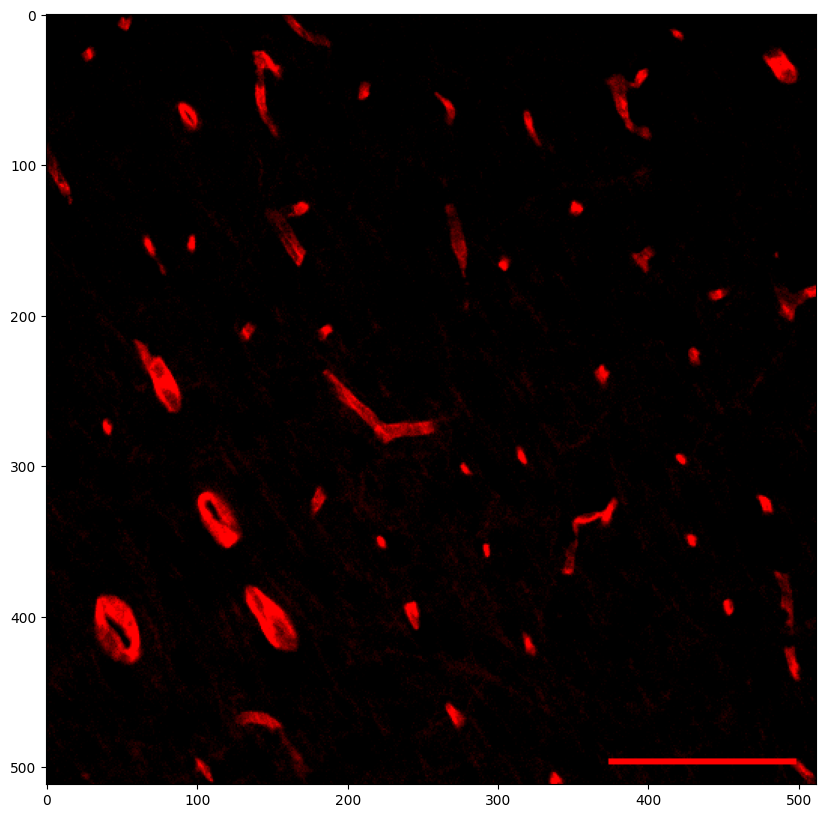

In [5]:
image_path = r'imgs/img1.png'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = adjust_histogram(image)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Load and prepare the model

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [6]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

predictor.set_image(image)

## OPTION I: Selecting objects with SAM

To select the object:

Left click = object (green dot) \\
Right click = background (red dot)

Multiple points can be input.
The chosen points will be shown as stars on the image.

In [7]:
points, _, labels = annotate_image(image)
input_point = np.array(points)
input_label = np.array(labels)

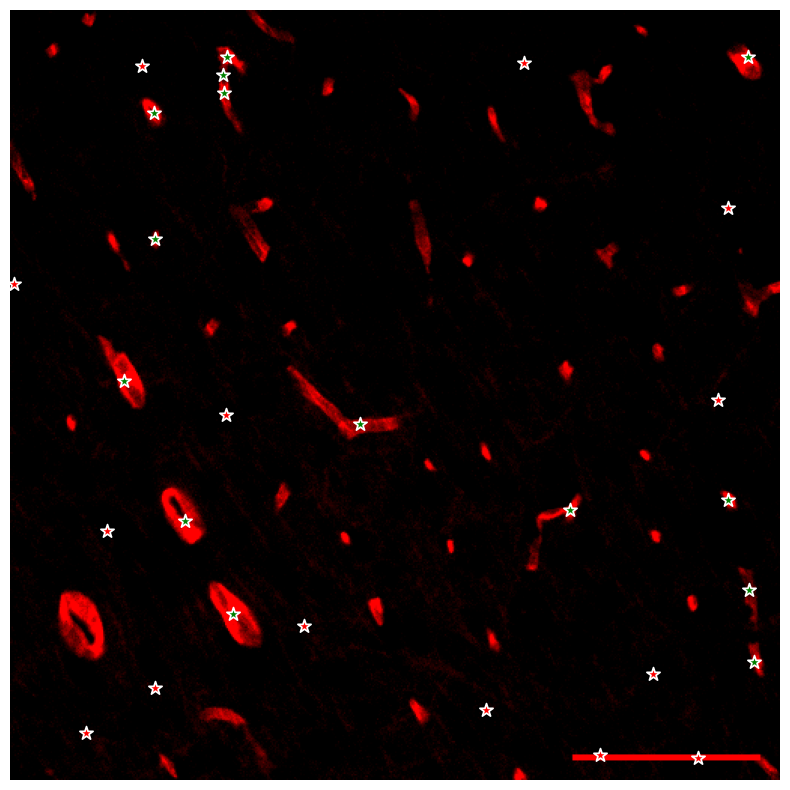

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()  

Predict with `SamPredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

In [9]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = np.array((0, 0, image.shape[1], image.shape[0])),
    multimask_output=True,
)

With `multimask_output=True` (the default setting), SAM outputs 3 masks, where `scores` gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When `False`, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in `scores`. This will often result in a better mask.

In [10]:
masks.shape  # (number_of_masks) x H x W

(3, 512, 512)

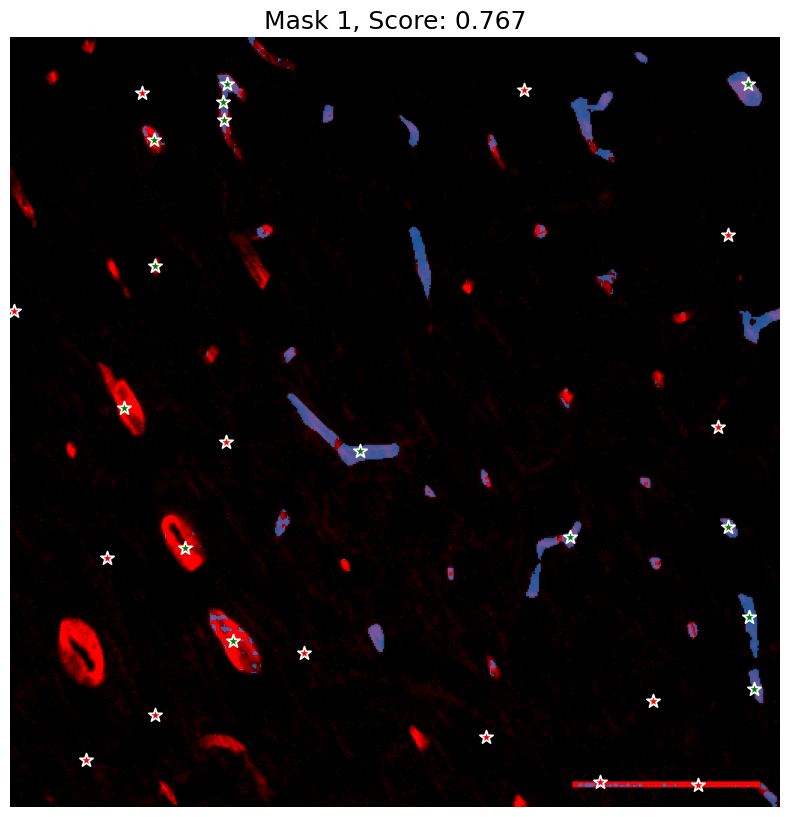

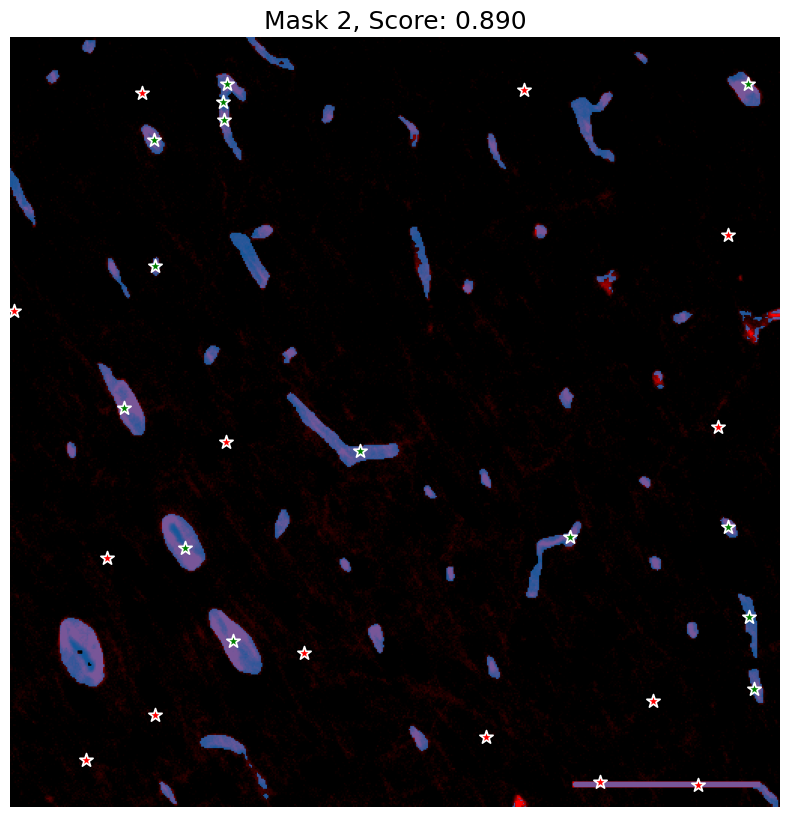

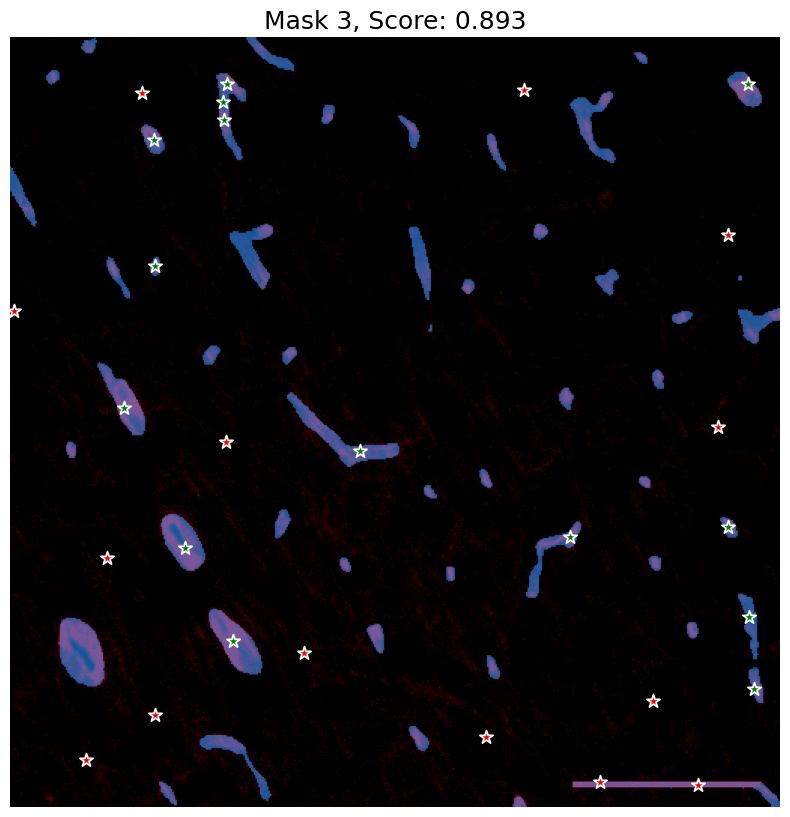

In [11]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

## OPTION I-A: Updating existing mask with additional points

Mayble, the points were not enough, and the model has returned multiple objects consistent with it. Select the best mask from the previous step and add new points to update the previous mask.

In [12]:
best_mask = 3

In [13]:
points, _, labels = annotate_image(image)
input_point = np.array(points)
input_label = np.array(labels)

mask_input = logits[best_mask - 1, :, :]  # Choose the model's best mask
# mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [14]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

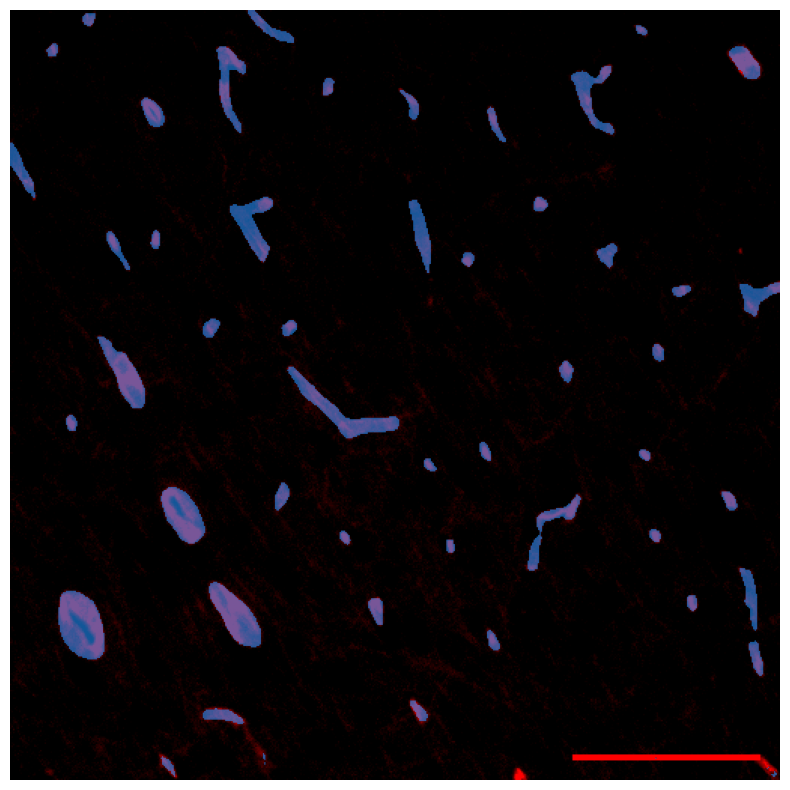

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
# show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

## OPTION II: Specifying a specific object with a box

The model can also take a box as input, and provide the mask inside the box.

When the annotator is shown, hit "b" to switch to box mode and draw a box around an object.

In [16]:
_, boxes, _ = annotate_image(image)
input_box = np.array(boxes)[0, ...]
input_label = np.array([1])

Switched to box annotation mode


In [17]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box,
    multimask_output=False,
)

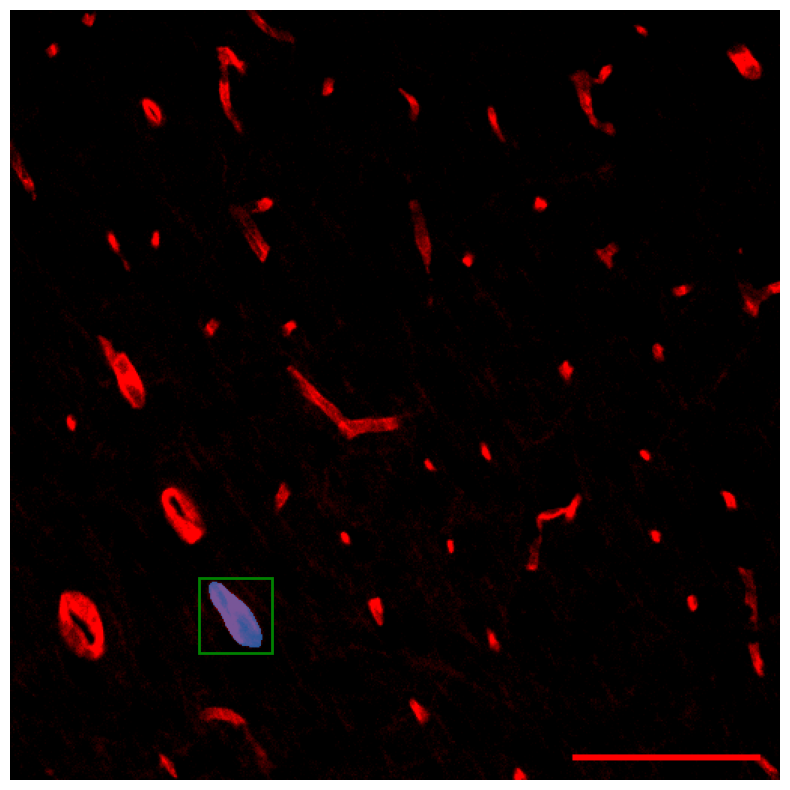

In [18]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

## OPTION III:Finding points in a box

Points and box may be combined, just by including both types of prompts to the predictor.

Annotate the points with left click (foreground) and right click (background).

Draw one box to delineate the ROI.

Switch between point mode and box mode with keyboard shortcuts (b = box mode | p = point mode)

In [22]:
points, boxex, labels = annotate_image(image)
input_point = np.array(points)
input_label = np.array(labels)
input_box = np.array(boxex)[0, ...]

Switched to box annotation mode
Switched to point annotation mode


In [23]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

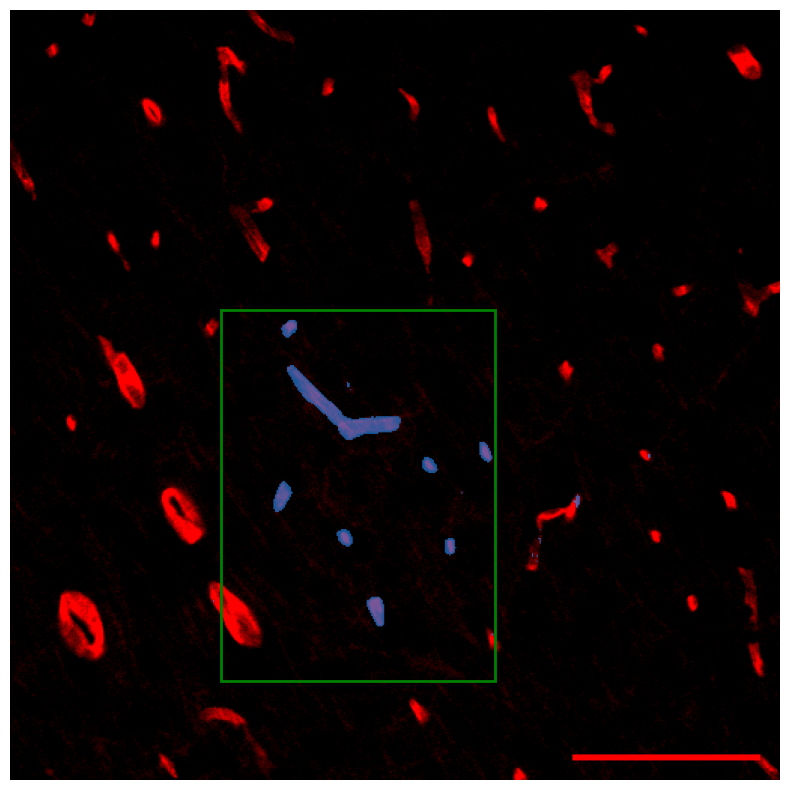

In [24]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
# show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

## OPTION IV: Finding the masks inside the boxes

Draw boxes around objects to find the masks.

Switch to box mode (keyboard shortcut b)

In [25]:
_, boxes, _ = annotate_image(image)
input_boxes = torch.tensor(boxes, device=predictor.device)

Switched to box annotation mode


Transform the boxes to the input frame, then predict masks. `SamPredictor` stores the necessary transform as the `transform` field for easy access, though it can also be instantiated directly for use in e.g. a dataloader (see `segment_anything.utils.transforms`).

In [26]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

In [27]:
print(input_boxes.shape)
print(masks.shape)  # (batch_size) x (num_predicted_masks_per_input) x H x W

torch.Size([7, 4])
torch.Size([7, 1, 512, 512])


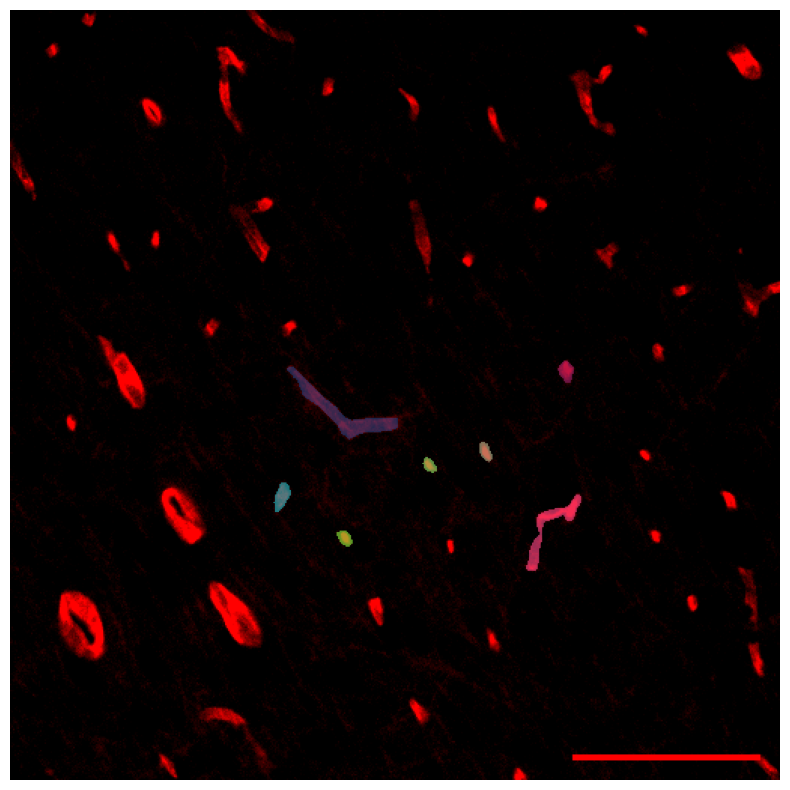

In [28]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
# for box in input_boxes:
#     show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()